# <center> Optimized Arima <center>

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

scipy: 0.19.0
numpy: 1.12.1
matplotlib: 2.0.1
pandas: 0.20.1
sklearn: 0.18.1
statsmodels: 0.8.0


---
## Problem Description

The problem is to predict annual water usage.

The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.

The values are in the units of liters per capita per day, and there are 79 observations.

The dataset is credited to Hipel and McLeod, 1994.

---
## Validation Set

In [2]:
from pandas import Series
series = Series.from_csv('water.csv', header=0)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 69, Validation 10


The specific contents of these files are:

    dataset.csv: Observations from 1885 to 1953 (69 observations).
    validation.csv: Observations from 1954 to 1963 (10 observations).
    
The validation dataset is about 12% of the original dataset.

---
## Baseline

The baseline prediction for time series forecasting is called the naive forecast, or persistence.

This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=522
>Predicted=522.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=450
>Predicted=450.000, Expected=432
>Predicted=432.000, Expected=432
>Predicted=432.000, Expected=458
>Predicted=458.000, Expected=462
>Predicted=462.000, Expected=503
>Predicted=503.000, Expected=488
>Predicted=488.000, Expected=466
>Predicted=466.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=500
>Predicted=500.000, Expected=522
>Predicted=522.000, Expected=575
>Predicted=575.000, Expected=583
>Predicted=583.000, Expected=587
>Predicted=587.000, Expected=628
>Predicted=628.000, Expected=640
>Predicted=640.000, Expected=609
>Predicted=609.000, Expected=606
>Predicted=606.000, Expected=632
>Predicted=632.000, Expected=617
>Predicted=617.000, Expected=613
>Predicted

---
## Data Analysis

In [4]:
series.describe()

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
dtype: float64

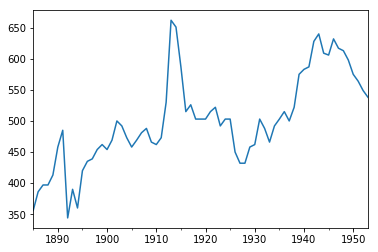

In [5]:
series.plot()
matplotlib.pyplot.show()

There may be some benefit in explicitly modeling the trend component and removing it. You may also explore using differencing with one or two levels in order to make the series stationary.

Reviewing plots of the density of observations can provide further insight into the structure of the data.

The example below creates a histogram and density plot of the observations without any temporal structure.

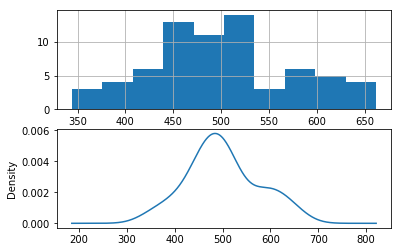

In [6]:
matplotlib.pyplot.figure(1)
matplotlib.pyplot.subplot(211)
series.hist()
matplotlib.pyplot.subplot(212)
series.plot(kind='kde')
matplotlib.pyplot.show()

Some observations from the plots include:

    -The distribution is not Gaussian, but is pretty close.
    -The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

#### Box and Whisker Plots

We can group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.

We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.

The example below groups the observations by decade and creates one box and whisker plot for each decade of observations. The last decade only contains 9 years and may not be a useful comparison with the other decades. Therefore only data between 1885 and 1944 was plotted.

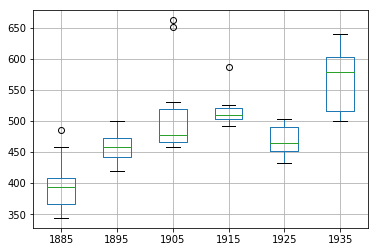

In [7]:
from pandas import DataFrame
from pandas import TimeGrouper
groups = series['1885':'1944'].groupby(TimeGrouper('10AS'))
decades = DataFrame()
for name, group in groups:
    decades[name.year] = group.values
decades.boxplot()
matplotlib.pyplot.show()

Running the example creates 6 box and whisker plots side-by-side, one for the 6 decades of selected data.

Some observations from reviewing the plot include:

    -The median values for each year (red line) may show an increasing trend that may not be linear.
    -The spread, or middle 50% of the data (blue boxes), does show some variability.
    -There maybe outliers in some decades (crosses outside of the box and whiskers).
    -The second to last decade seems to have a lower average consumption, perhaps related to the first world war.

#### ARIMA Models

We will develop Autoregressive Integrated Moving Average or ARIMA models for the problem.

We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

As such, this section is broken down into 3 steps:

   - Manually Configure the ARIMA.
   - Automatically Configure the ARIMA.
   - Review Residual Errors.

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.

Analysis of the time series data assumes that we are working with a stationary time series.

The time series is likely non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller

/home/antonio/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	10%: -2.591
	5%: -2.906
	1%: -3.534


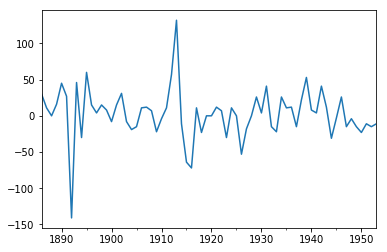

In [9]:
# create a differe
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
 
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:] # lost the first observation
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
matplotlib.pyplot.show()

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

The next first step is to select the **lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.**

We can do this by reviewing **Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.**

The example below creates ACF and PACF plots for the series.

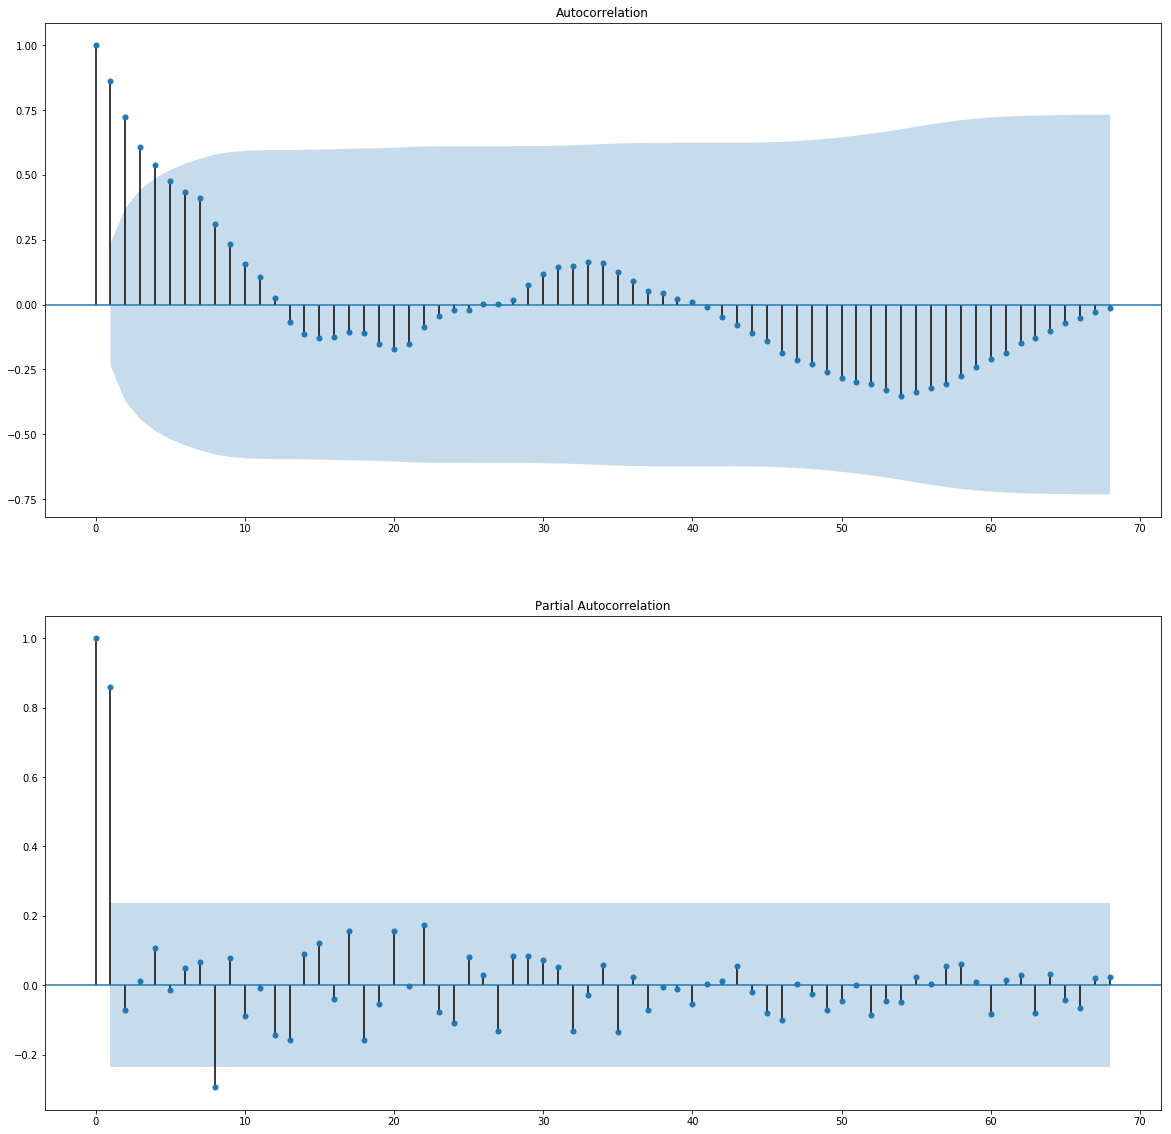

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
matplotlib.pyplot.figure(figsize=(20,20))
matplotlib.pyplot.subplot(211)
plot_acf(series, ax=matplotlib.pyplot.gca())
matplotlib.pyplot.subplot(212)
plot_pacf(series, ax=matplotlib.pyplot.gca())
matplotlib.pyplot.show()

Let's try an ARIMA(0,1,0):

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=507.455, Expected=503
>Predicted=507.324, Expected=503
>Predicted=507.200, Expected=515
>Predicted=519.417, Expected=522
>Predicted=526.486, Expected=492
>Predicted=495.579, Expected=503
>Predicted=506.769, Expected=503
>Predicted=506.675, Expected=450
>Predicted=452.293, Expected=432
>Predicted=433.810, Expected=432
>Predicted=433.767, Expected=458
>Predicted=460.318, Expected=462
>Predicted=464.356, Expected=503
>Predicted=506.196, Expected=488
>Predicted=490.809, Expected=466
>Predicted=468.292, Expected=492
>Predicted=494.776, Expected=503
>Predicted=505.940, Expected=515
>Predicted=518.118, Expected=500
>Predicted=502.769, Expected=522
>Predicted=525.132, Expected=575
>Predicted=579.056, Expected=583
>Predicted=587.127, Expected=587
>Predicted=591.125, Expected=628
>Predicted=632.772, Expected=640
>Predicted=644.897, Expected=609
>Predicted=613.288, Expected=606
>Predicted=610.167, Expected=632
>Predicted=636.525, Expected=617
>Predicted=621.210, Expected=613
>Predicted

Running this example results in an RMSE of 22.311, which is slightly higher than the persistence model above.

This may be because of the details of the ARIMA implementation, such as an automatic trend constant that is calculated and added.

#### Grid Search ARIMA Hyperparameters

In [13]:
import warnings
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.656
ARIMA(0, 0, 4) RMSE=77.343
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.182
ARIMA(0, 1, 3) RMSE=24.733
ARIMA(0, 1, 4) RMSE=24.845
ARIMA(0, 2, 1) RMSE=22.381
ARIMA(0, 2, 2) RMSE=22.244
ARIMA(1, 0, 0) RMSE=21.996
ARIMA(1, 1, 0) RMSE=21.922
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.271
ARIMA(2, 1, 0) RMSE=21.733
ARIMA(2, 2, 0) RMSE=25.282
ARIMA(3, 1, 0) RMSE=24.270
ARIMA(3, 1, 1) RMSE=25.491
ARIMA(3, 2, 0) RMSE=25.625
ARIMA(3, 2, 1) RMSE=25.008
ARIMA(4, 0, 0) RMSE=25.374
ARIMA(4, 1, 0) RMSE=24.802
ARIMA(4, 1, 1) RMSE=25.103
ARIMA(4, 2, 0) RMSE=27.089
ARIMA(4, 2, 1) RMSE=25.933
ARIMA(4, 2, 2) RMSE=25.418
Best ARIMA(2, 1, 0) RMSE=21.733


The results show that the best configuration discovered was ARIMA(2, 1, 0) with an RMSE of 21.733, slightly lower than the manual persistence model tested earlier, but may or may not be significantly different.

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(2, 1, 0) model.

               0
count  35.000000
mean    1.081624
std    22.022566
min   -52.103811
25%   -16.202284
50%    -0.459805
75%    12.085091
max    51.284339


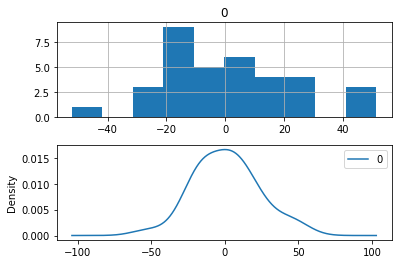

In [14]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
matplotlib.pyplot.figure()
matplotlib.pyplot.subplot(211)
residuals.hist(ax=matplotlib.pyplot.gca())
matplotlib.pyplot.subplot(212)
residuals.plot(kind='kde', ax=matplotlib.pyplot.gca())
matplotlib.pyplot.show()

We could use this information to bias-correct predictions by adding the mean residual error of 1.081624 to each forecast made.

In [17]:
bias = 1.081624
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0, trend="nc")
    yhat = bias + model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=502.715, Expected=503
>Predicted=505.894, Expected=503
>Predicted=504.082, Expected=515
>Predicted=516.336, Expected=522
>Predicted=522.296, Expected=492
>Predicted=491.911, Expected=503
>Predicted=506.711, Expected=503
>Predicted=503.185, Expected=450
>Predicted=450.362, Expected=432
>Predicted=437.369, Expected=432
>Predicted=434.646, Expected=458
>Predicted=459.810, Expected=462
>Predicted=460.773, Expected=503
>Predicted=505.057, Expected=488
>Predicted=485.536, Expected=466
>Predicted=467.835, Expected=492
>Predicted=495.632, Expected=503
>Predicted=501.814, Expected=515
>Predicted=515.361, Expected=500
>Predicted=499.634, Expected=522
>Predicted=524.797, Expected=575
>Predicted=575.576, Expected=583
>Predicted=579.191, Expected=587
>Predicted=587.500, Expected=628
>Predicted=630.397, Expected=640
>Predicted=638.047, Expected=609
>Predicted=607.541, Expected=606
>Predicted=610.112, Expected=632
>Predicted=634.511, Expected=617
>Predicted=614.670, Expected=613
>Predicted